# Comparing both approaches

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simple Levenshtein distance implementation (no external dependency needed)
def levenshtein_distance(s1, s2):
    """Calculate the Levenshtein distance between two strings."""
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            # Cost of insertions, deletions, or substitutions
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load the data
df = pd.read_csv('../output/test-neutral.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (500, 8)

Columns: ['original_name', 'cleaned_name', 'cleaning_type', 'anomolous_features', 'InputFormClassification', 'sanitised_name', 'gliner_type', 'gliner_confidence']

First few rows:


,original_name,cleaned_name,cleaning_type,anomolous_features,InputFormClassification,sanitised_name,gliner_type,gliner_confidence
0,primary communication partners pty limited,Primary Communication Partners Pty Ltd,standardized,"['all-lowercase input', ""redundant legal form ...",company name,Primary Communication Partners PTY LTD,company name,0.562912
1,global valves & engineering pty ltd,Global Valves & Engineering Pty Ltd,standardized,[],company name,Global Valves & Engineering PTY LTD,company name,0.625377
2,fabege ab npv,Fabege AB NPV,standardized,"[""unknown suffix 'NPV' — ambiguous meaning (e....",company name,Fabege Ab Npv,ambiguous,0.000000
3,longtime dining,Longtime Dining,standardized,"['original all lowercase', 'generic/common wor...",company name,Longtime Dining,company name,0.646344
4,triptech limited,Triptech Ltd,standardized,[],company name,Triptech LTD,company name,0.806291


In [3]:
# Calculate Levenshtein distances
df['lev_dist_cleaned'] = df.apply(
    lambda row: levenshtein_distance(row['original_name'].lower(), row['cleaned_name'].lower()), 
    axis=1
)

df['lev_dist_sanitised'] = df.apply(
    lambda row: levenshtein_distance(row['original_name'].lower(), row['sanitised_name'].lower()), 
    axis=1
)

# Calculate normalized distances (as percentage of original length)
df['lev_dist_cleaned_norm'] = df.apply(
    lambda row: row['lev_dist_cleaned'] / len(row['original_name']) * 100 if len(row['original_name']) > 0 else 0,
    axis=1
)

df['lev_dist_sanitised_norm'] = df.apply(
    lambda row: row['lev_dist_sanitised'] / len(row['original_name']) * 100 if len(row['original_name']) > 0 else 0,
    axis=1
)

print("Levenshtein Distance Statistics:")
print("\nCleaned Name vs Original:")
print(df['lev_dist_cleaned'].describe())
print("\nSanitised Name vs Original:")
print(df['lev_dist_sanitised'].describe())


Levenshtein Distance Statistics:

Cleaned Name vs Original:
count    500.000000
mean       3.892000
std        7.982718
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max       63.000000
Name: lev_dist_cleaned, dtype: float64

Sanitised Name vs Original:
count    500.000000
mean       1.322000
std        3.567038
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       18.000000
Name: lev_dist_sanitised, dtype: float64


=== LENGTH CHANGES ===

Average length change:
  Cleaned:   +0.81 characters
  Sanitised: -0.91 characters


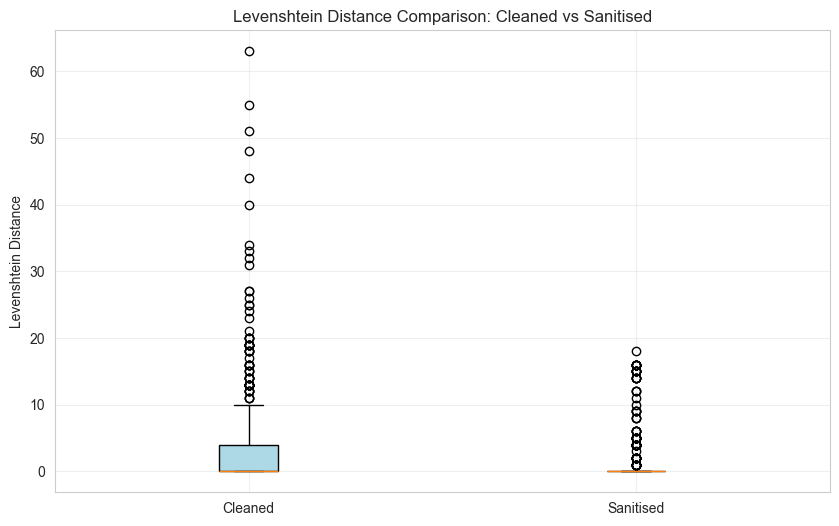

In [4]:
# Additional metrics: Length changes
df['len_original'] = df['original_name'].str.len()
df['len_cleaned'] = df['cleaned_name'].str.len()
df['len_sanitised'] = df['sanitised_name'].str.len()

df['len_change_cleaned'] = df['len_cleaned'] - df['len_original']
df['len_change_sanitised'] = df['len_sanitised'] - df['len_original']

print("=== LENGTH CHANGES ===")
print(f"\nAverage length change:")
print(f"  Cleaned:   {df['len_change_cleaned'].mean():+.2f} characters")
print(f"  Sanitised: {df['len_change_sanitised'].mean():+.2f} characters")

# Box plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
data_to_plot = [df['lev_dist_cleaned'], df['lev_dist_sanitised']]
bp = ax.boxplot(data_to_plot, tick_labels=['Cleaned', 'Sanitised'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('peachpuff')
ax.set_ylabel('Levenshtein Distance')
ax.set_title('Levenshtein Distance Comparison: Cleaned vs Sanitised')
ax.grid(True, alpha=0.3)
plt.show()


In [5]:
# Show examples with largest differences
print("=== EXAMPLES: Largest differences for CLEANED ===\n")
top_cleaned = df.nlargest(5, 'lev_dist_cleaned')[['original_name', 'cleaned_name', 'lev_dist_cleaned']]
for idx, row in top_cleaned.iterrows():
    print(f"Original:  {row['original_name']}")
    print(f"Cleaned:   {row['cleaned_name']}")
    print(f"Distance:  {row['lev_dist_cleaned']}")
    print()

print("\n=== EXAMPLES: Largest differences for SANITISED ===\n")
top_sanitised = df.nlargest(5, 'lev_dist_sanitised')[['original_name', 'sanitised_name', 'lev_dist_sanitised']]
for idx, row in top_sanitised.iterrows():
    print(f"Original:   {row['original_name']}")
    print(f"Sanitised:  {row['sanitised_name']}")
    print(f"Distance:   {row['lev_dist_sanitised']}")
    print()


=== EXAMPLES: Largest differences for CLEANED ===

Original:  gnr 2013-5 ip 3.5 13-20/jan/43
Cleaned:   Issuer: GNR; Instrument: 2013-5 IP; Coupon: 3.5%; Maturity: 13–20 Jan '43 (year ambiguous)
Distance:  63

Original:  fnma 40yr modified step rate
Cleaned:   Federal National Mortgage Association (FNMA) — 40-year modified step-rate security
Distance:  55

Original:  planview parent, inc.-closing date loan (second lien) cme term sofr+7.25
Cleaned:   Planview Parent, Inc.
Distance:  51

Original:  td nab 24jun24 5.20%
Cleaned:   National Australia Bank - Term Deposit maturing 24 Jun 2024, 5.20%
Distance:  48

Original:  上海力点数码科技有限公司
Cleaned:   Shanghai Lidian Digital Technology Co., Ltd.
Distance:  44


=== EXAMPLES: Largest differences for SANITISED ===

Original:   pref series 2024-1a class d 6.770% 10/15/2030 (usd)
Sanitised:  Pref Series 2024-1A Class D (Usd)
Distance:   18

Original:   ooh!media street furniture pl abn 77000081872
Sanitised:  Ooh!Media Street Furniture PTY LTD Abn


=== WHICH APPROACH STAYS CLOSER TO ORIGINAL? ===

which_closer
same         298
sanitised    174
cleaned       28
Name: count, dtype: int64

Percentages:
  Cleaned closer:   5.6%
  Sanitised closer: 34.8%
  Same distance:    59.6%


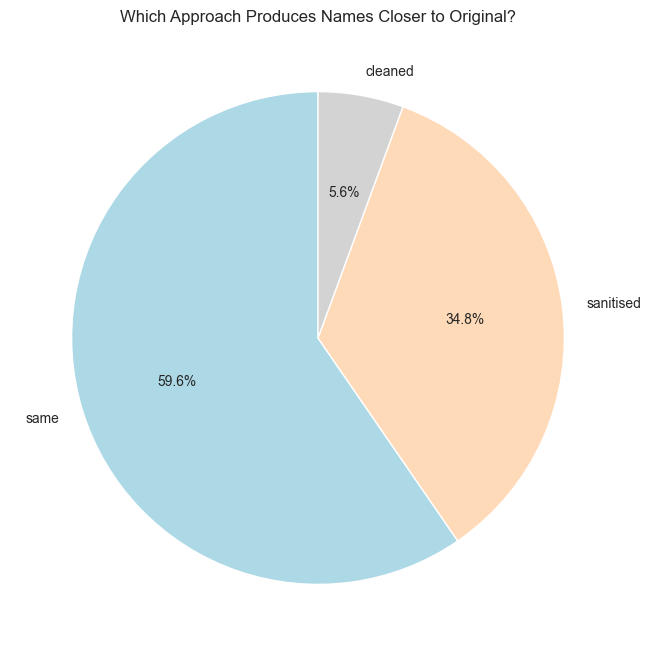

In [6]:
# Which approach modifies less?
df['which_closer'] = df.apply(
    lambda row: 'cleaned' if row['lev_dist_cleaned'] < row['lev_dist_sanitised'] 
    else ('sanitised' if row['lev_dist_sanitised'] < row['lev_dist_cleaned'] else 'same'),
    axis=1
)

print("=== WHICH APPROACH STAYS CLOSER TO ORIGINAL? ===\n")
closer_counts = df['which_closer'].value_counts()
print(closer_counts)
print(f"\nPercentages:")
print(f"  Cleaned closer:   {closer_counts.get('cleaned', 0) / len(df) * 100:.1f}%")
print(f"  Sanitised closer: {closer_counts.get('sanitised', 0) / len(df) * 100:.1f}%")
print(f"  Same distance:    {closer_counts.get('same', 0) / len(df) * 100:.1f}%")

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['lightblue', 'peachpuff', 'lightgray']
ax.pie(closer_counts.values, labels=closer_counts.index, autopct='%1.1f%%', 
       colors=colors, startangle=90)
ax.set_title('Which Approach Produces Names Closer to Original?')
plt.show()


=== STRING SIMILARITY METRICS ===

Sequence Similarity (0=different, 1=identical):
  Cleaned:   0.932
  Sanitised: 0.975

Token Overlap (Jaccard):
  Cleaned:   0.758
  Sanitised: 0.925


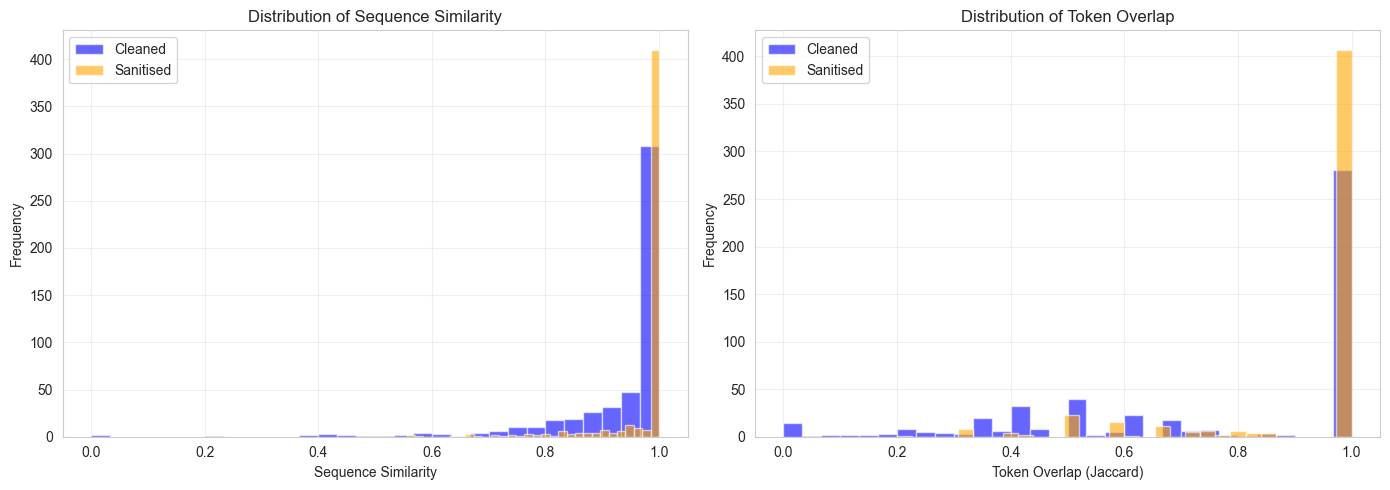

In [7]:
# ============================================
# ADDITIONAL METRICS: STRING SIMILARITY
# ============================================

from difflib import SequenceMatcher

def sequence_similarity(s1, s2):
    """Calculate sequence similarity ratio (0-1, higher = more similar)"""
    return SequenceMatcher(None, s1, s2).ratio()

def token_overlap(s1, s2):
    """Calculate Jaccard similarity of tokens"""
    tokens1 = set(s1.lower().split())
    tokens2 = set(s2.lower().split())
    if not tokens1 and not tokens2:
        return 1.0
    intersection = len(tokens1.intersection(tokens2))
    union = len(tokens1.union(tokens2))
    return intersection / union if union > 0 else 0

# Calculate similarities
df['similarity_cleaned'] = df.apply(
    lambda row: sequence_similarity(row['original_name'].lower(), row['cleaned_name'].lower()), 
    axis=1
)
df['similarity_sanitised'] = df.apply(
    lambda row: sequence_similarity(row['original_name'].lower(), row['sanitised_name'].lower()), 
    axis=1
)

df['token_overlap_cleaned'] = df.apply(
    lambda row: token_overlap(row['original_name'], row['cleaned_name']), 
    axis=1
)
df['token_overlap_sanitised'] = df.apply(
    lambda row: token_overlap(row['original_name'], row['sanitised_name']), 
    axis=1
)

print("=== STRING SIMILARITY METRICS ===")
print(f"\nSequence Similarity (0=different, 1=identical):")
print(f"  Cleaned:   {df['similarity_cleaned'].mean():.3f}")
print(f"  Sanitised: {df['similarity_sanitised'].mean():.3f}")
print(f"\nToken Overlap (Jaccard):")
print(f"  Cleaned:   {df['token_overlap_cleaned'].mean():.3f}")
print(f"  Sanitised: {df['token_overlap_sanitised'].mean():.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['similarity_cleaned'], bins=30, alpha=0.6, label='Cleaned', color='blue')
axes[0].hist(df['similarity_sanitised'], bins=30, alpha=0.6, label='Sanitised', color='orange')
axes[0].set_xlabel('Sequence Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sequence Similarity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(df['token_overlap_cleaned'], bins=30, alpha=0.6, label='Cleaned', color='blue')
axes[1].hist(df['token_overlap_sanitised'], bins=30, alpha=0.6, label='Sanitised', color='orange')
axes[1].set_xlabel('Token Overlap (Jaccard)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Token Overlap')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== TOKEN CHANGES ===

Average number of tokens:
  Original:  3.95
  Cleaned:   4.07
  Sanitised: 3.83

Average tokens added/removed:
  Cleaned:   +0.12
  Sanitised: -0.12


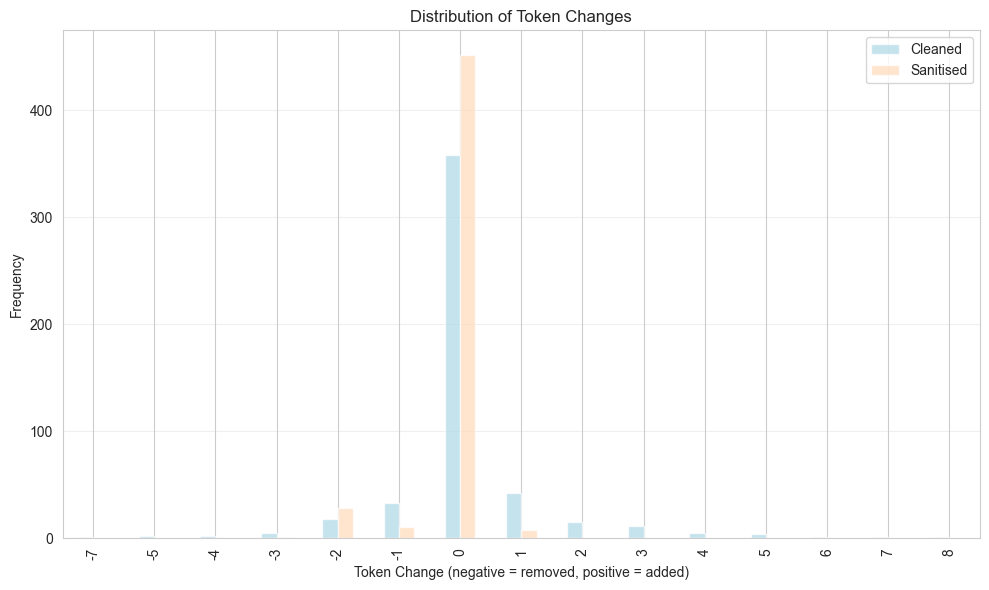

In [8]:
# ============================================
# TOKEN-LEVEL CHANGES
# ============================================

# Count number of words (tokens)
df['tokens_original'] = df['original_name'].str.split().str.len()
df['tokens_cleaned'] = df['cleaned_name'].str.split().str.len()
df['tokens_sanitised'] = df['sanitised_name'].str.split().str.len()

df['token_change_cleaned'] = df['tokens_cleaned'] - df['tokens_original']
df['token_change_sanitised'] = df['tokens_sanitised'] - df['tokens_original']

print("=== TOKEN CHANGES ===")
print(f"\nAverage number of tokens:")
print(f"  Original:  {df['tokens_original'].mean():.2f}")
print(f"  Cleaned:   {df['tokens_cleaned'].mean():.2f}")
print(f"  Sanitised: {df['tokens_sanitised'].mean():.2f}")
print(f"\nAverage tokens added/removed:")
print(f"  Cleaned:   {df['token_change_cleaned'].mean():+.2f}")
print(f"  Sanitised: {df['token_change_sanitised'].mean():+.2f}")

# Distribution of token changes
fig, ax = plt.subplots(figsize=(10, 6))
token_changes = pd.DataFrame({
    'Cleaned': df['token_change_cleaned'].value_counts().sort_index(),
    'Sanitised': df['token_change_sanitised'].value_counts().sort_index()
}).fillna(0)

token_changes.plot(kind='bar', ax=ax, color=['lightblue', 'peachpuff'], alpha=0.7)
ax.set_xlabel('Token Change (negative = removed, positive = added)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Token Changes')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


=== CHANGE CATEGORIES ===

Cleaned:
change_type_cleaned
no_change          279
minor_edit         119
major_edit          58
major_reduction     24
major_expansion     20
Name: count, dtype: int64

Sanitised:
change_type_sanitised
no_change          405
minor_edit          56
major_edit          20
major_reduction     19
Name: count, dtype: int64


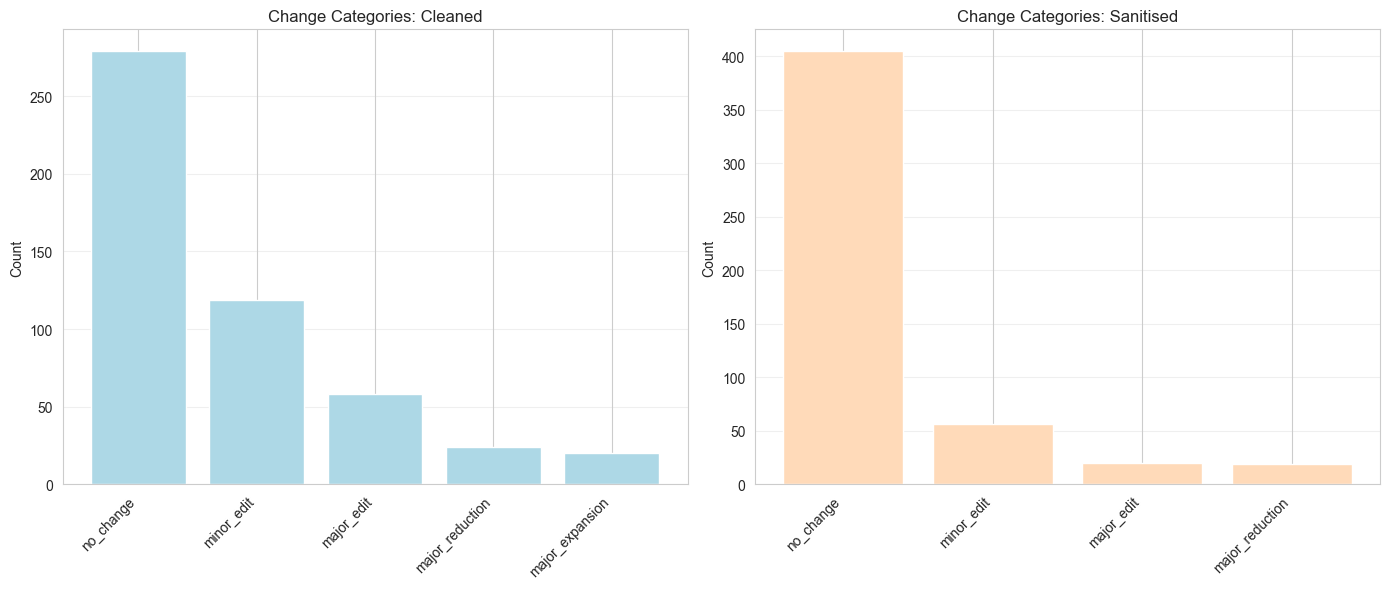

In [9]:
# ============================================
# CHANGE CATEGORIES
# ============================================

def categorize_change(original, modified, lev_dist):
    """Categorize the type of change made"""
    if lev_dist == 0:
        return 'no_change'
    elif modified.lower() == original.lower():
        return 'case_only'
    elif len(modified) > len(original) * 1.5:
        return 'major_expansion'
    elif len(modified) < len(original) * 0.7:
        return 'major_reduction'
    elif lev_dist <= 5:
        return 'minor_edit'
    else:
        return 'major_edit'

df['change_type_cleaned'] = df.apply(
    lambda row: categorize_change(row['original_name'], row['cleaned_name'], row['lev_dist_cleaned']),
    axis=1
)
df['change_type_sanitised'] = df.apply(
    lambda row: categorize_change(row['original_name'], row['sanitised_name'], row['lev_dist_sanitised']),
    axis=1
)

print("=== CHANGE CATEGORIES ===")
print("\nCleaned:")
print(df['change_type_cleaned'].value_counts())
print("\nSanitised:")
print(df['change_type_sanitised'].value_counts())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

change_counts_cleaned = df['change_type_cleaned'].value_counts()
change_counts_sanitised = df['change_type_sanitised'].value_counts()

axes[0].bar(range(len(change_counts_cleaned)), change_counts_cleaned.values, color='lightblue')
axes[0].set_xticks(range(len(change_counts_cleaned)))
axes[0].set_xticklabels(change_counts_cleaned.index, rotation=45, ha='right')
axes[0].set_ylabel('Count')
axes[0].set_title('Change Categories: Cleaned')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(len(change_counts_sanitised)), change_counts_sanitised.values, color='peachpuff')
axes[1].set_xticks(range(len(change_counts_sanitised)))
axes[1].set_xticklabels(change_counts_sanitised.index, rotation=45, ha='right')
axes[1].set_ylabel('Count')
axes[1].set_title('Change Categories: Sanitised')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


=== CHARACTER TYPE CHANGES ===

Average digit changes:
  Cleaned:   -0.26
  Sanitised: -0.66

Average special character changes:
  Cleaned:   +0.21
  Sanitised: -0.20

Average uppercase letter changes:
  Cleaned:   4.18
  Sanitised: 5.10


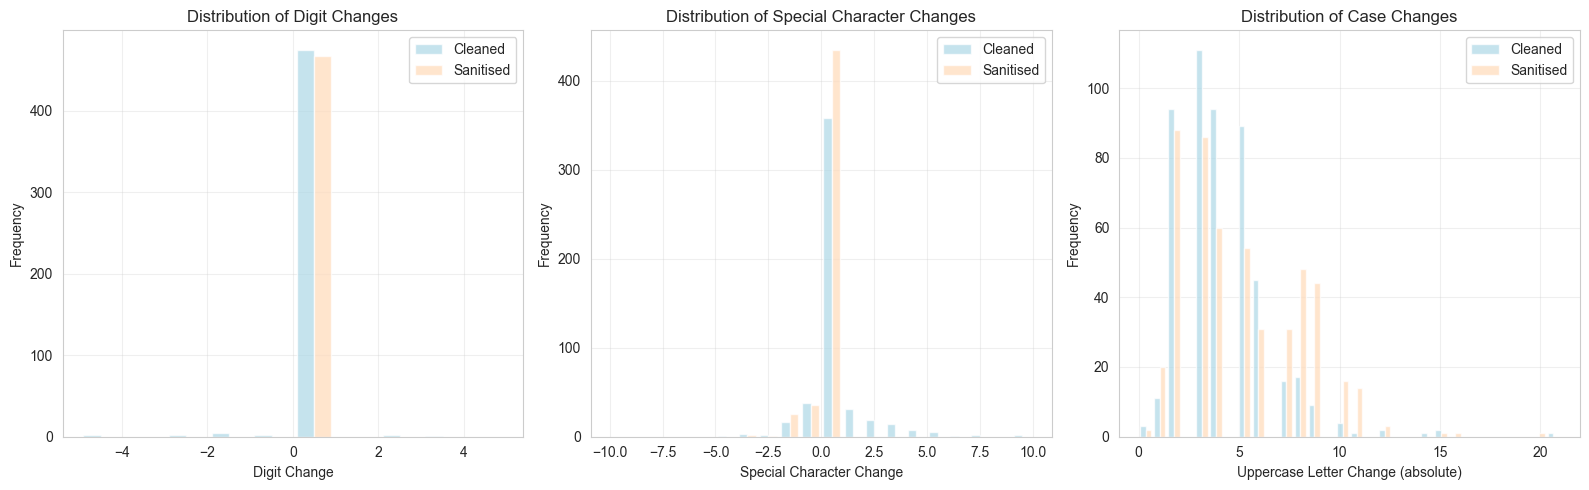

In [10]:
# ============================================
# CHARACTER TYPE ANALYSIS
# ============================================

import re

# Count digits
df['digits_original'] = df['original_name'].str.count(r'\d')
df['digits_cleaned'] = df['cleaned_name'].str.count(r'\d')
df['digits_sanitised'] = df['sanitised_name'].str.count(r'\d')

# Count special characters
df['special_chars_original'] = df['original_name'].str.count(r'[^\w\s]')
df['special_chars_cleaned'] = df['cleaned_name'].str.count(r'[^\w\s]')
df['special_chars_sanitised'] = df['sanitised_name'].str.count(r'[^\w\s]')

# Count uppercase letters
df['upper_original'] = df['original_name'].str.count(r'[A-Z]')
df['upper_cleaned'] = df['cleaned_name'].str.count(r'[A-Z]')
df['upper_sanitised'] = df['sanitised_name'].str.count(r'[A-Z]')

# Calculate changes
df['digit_change_cleaned'] = df['digits_cleaned'] - df['digits_original']
df['digit_change_sanitised'] = df['digits_sanitised'] - df['digits_original']
df['special_change_cleaned'] = df['special_chars_cleaned'] - df['special_chars_original']
df['special_change_sanitised'] = df['special_chars_sanitised'] - df['special_chars_original']
df['case_change_cleaned'] = abs(df['upper_cleaned'] - df['upper_original'])
df['case_change_sanitised'] = abs(df['upper_sanitised'] - df['upper_original'])

print("=== CHARACTER TYPE CHANGES ===")
print(f"\nAverage digit changes:")
print(f"  Cleaned:   {df['digit_change_cleaned'].mean():+.2f}")
print(f"  Sanitised: {df['digit_change_sanitised'].mean():+.2f}")
print(f"\nAverage special character changes:")
print(f"  Cleaned:   {df['special_change_cleaned'].mean():+.2f}")
print(f"  Sanitised: {df['special_change_sanitised'].mean():+.2f}")
print(f"\nAverage uppercase letter changes:")
print(f"  Cleaned:   {df['case_change_cleaned'].mean():.2f}")
print(f"  Sanitised: {df['case_change_sanitised'].mean():.2f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Digit changes
axes[0].hist([df['digit_change_cleaned'], df['digit_change_sanitised']], 
             bins=range(-5, 6), label=['Cleaned', 'Sanitised'], 
             color=['lightblue', 'peachpuff'], alpha=0.7)
axes[0].set_xlabel('Digit Change')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Digit Changes')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Special character changes
axes[1].hist([df['special_change_cleaned'], df['special_change_sanitised']], 
             bins=range(-10, 11), label=['Cleaned', 'Sanitised'], 
             color=['lightblue', 'peachpuff'], alpha=0.7)
axes[1].set_xlabel('Special Character Change')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Special Character Changes')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Case changes
axes[2].hist([df['case_change_cleaned'], df['case_change_sanitised']], 
             bins=30, label=['Cleaned', 'Sanitised'], 
             color=['lightblue', 'peachpuff'], alpha=0.7)
axes[2].set_xlabel('Uppercase Letter Change (absolute)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Distribution of Case Changes')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== CORRELATION ANALYSIS ===

Correlation between original length and edit distance:
  Cleaned:   0.387
  Sanitised: 0.315

Correlation between token count and edit distance:
  Cleaned:   0.382
  Sanitised: 0.274


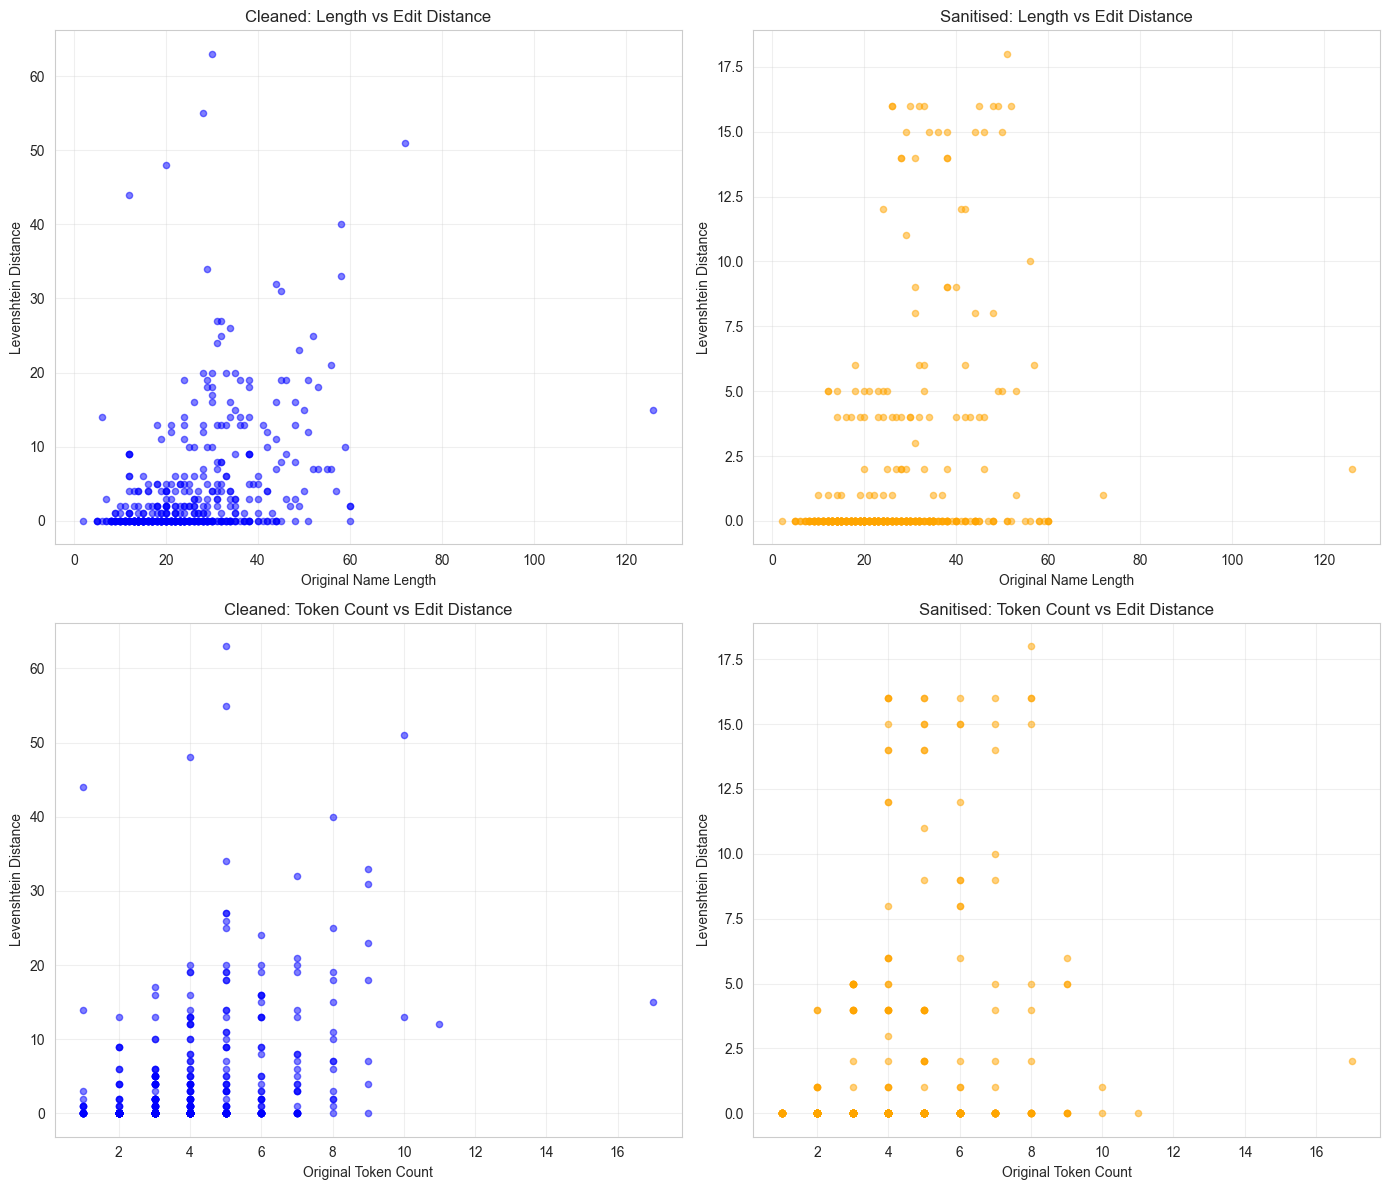

In [11]:
# ============================================
# CORRELATION ANALYSIS
# ============================================

print("=== CORRELATION ANALYSIS ===")
print(f"\nCorrelation between original length and edit distance:")
print(f"  Cleaned:   {df['len_original'].corr(df['lev_dist_cleaned']):.3f}")
print(f"  Sanitised: {df['len_original'].corr(df['lev_dist_sanitised']):.3f}")

print(f"\nCorrelation between token count and edit distance:")
print(f"  Cleaned:   {df['tokens_original'].corr(df['lev_dist_cleaned']):.3f}")
print(f"  Sanitised: {df['tokens_original'].corr(df['lev_dist_sanitised']):.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Length vs Edit Distance
axes[0, 0].scatter(df['len_original'], df['lev_dist_cleaned'], alpha=0.5, s=20, color='blue')
axes[0, 0].set_xlabel('Original Name Length')
axes[0, 0].set_ylabel('Levenshtein Distance')
axes[0, 0].set_title('Cleaned: Length vs Edit Distance')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(df['len_original'], df['lev_dist_sanitised'], alpha=0.5, s=20, color='orange')
axes[0, 1].set_xlabel('Original Name Length')
axes[0, 1].set_ylabel('Levenshtein Distance')
axes[0, 1].set_title('Sanitised: Length vs Edit Distance')
axes[0, 1].grid(True, alpha=0.3)

# Token count vs Edit Distance
axes[1, 0].scatter(df['tokens_original'], df['lev_dist_cleaned'], alpha=0.5, s=20, color='blue')
axes[1, 0].set_xlabel('Original Token Count')
axes[1, 0].set_ylabel('Levenshtein Distance')
axes[1, 0].set_title('Cleaned: Token Count vs Edit Distance')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['tokens_original'], df['lev_dist_sanitised'], alpha=0.5, s=20, color='orange')
axes[1, 1].set_xlabel('Original Token Count')
axes[1, 1].set_ylabel('Levenshtein Distance')
axes[1, 1].set_title('Sanitised: Token Count vs Edit Distance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== CLASSIFICATION ANALYSIS ===

Classification agreement rate: 60.2%
  Matches: 301 / 500

GLiNER classification distribution:
gliner_type
company name                             320
ambiguous                                109
individual person                         14
financial instrument                      13
company identifier                        13
address                                   11
government entity                          7
nonprofit entity                           7
educational and research institutions      3
product or service name                    3
Name: count, dtype: int64

Average GLiNER confidence by entity type:
                                           mean  count
gliner_type                                           
address                                0.826477     11
government entity                      0.798881      7
financial instrument                   0.772856     13
individual person                      0.727605     14
company nam

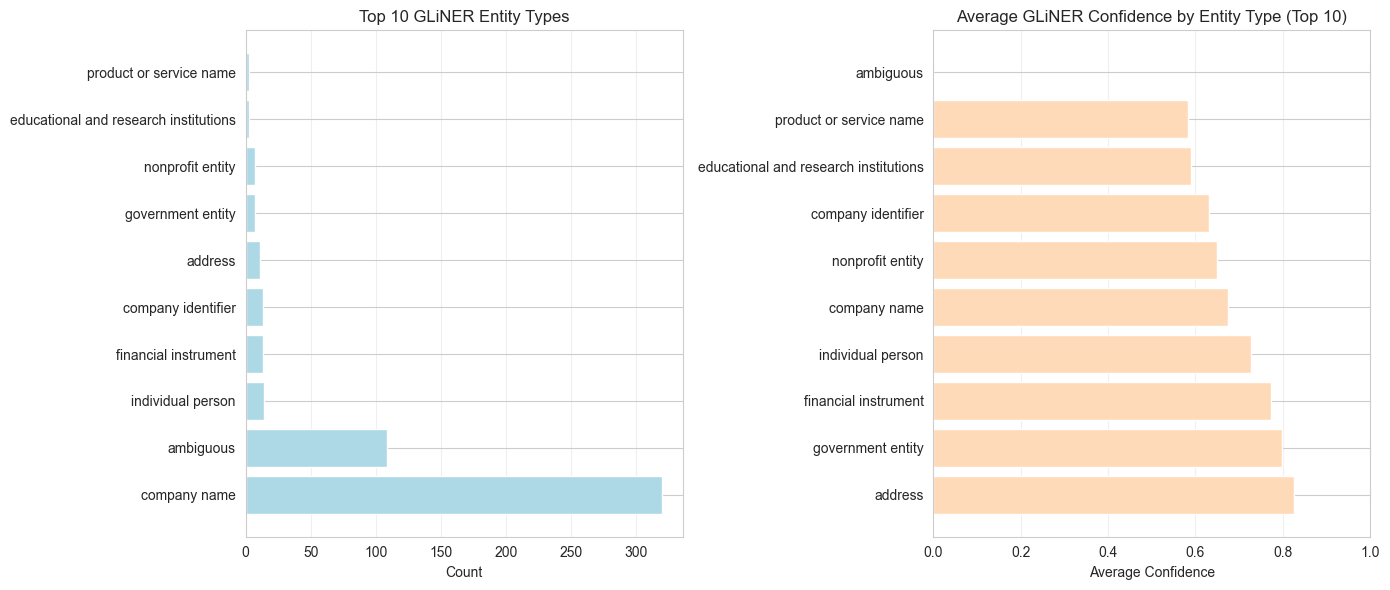

In [12]:
# ============================================
# CLASSIFICATION AGREEMENT
# ============================================

# Compare InputFormClassification with gliner_type
df['classification_match'] = (df['InputFormClassification'] == df['gliner_type'])

print("=== CLASSIFICATION ANALYSIS ===")
print(f"\nClassification agreement rate: {df['classification_match'].mean()*100:.1f}%")
print(f"  Matches: {df['classification_match'].sum()} / {len(df)}")

print(f"\nGLiNER classification distribution:")
print(df['gliner_type'].value_counts())

print(f"\nAverage GLiNER confidence by entity type:")
confidence_by_type = df.groupby('gliner_type')['gliner_confidence'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(confidence_by_type)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Classification distribution
gliner_counts = df['gliner_type'].value_counts().head(10)
axes[0].barh(range(len(gliner_counts)), gliner_counts.values, color='lightblue')
axes[0].set_yticks(range(len(gliner_counts)))
axes[0].set_yticklabels(gliner_counts.index)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 10 GLiNER Entity Types')
axes[0].grid(True, alpha=0.3, axis='x')

# Confidence by type
top_types = df.groupby('gliner_type')['gliner_confidence'].mean().sort_values(ascending=False).head(10)
axes[1].barh(range(len(top_types)), top_types.values, color='peachpuff')
axes[1].set_yticks(range(len(top_types)))
axes[1].set_yticklabels(top_types.index)
axes[1].set_xlabel('Average Confidence')
axes[1].set_title('Average GLiNER Confidence by Entity Type (Top 10)')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


=== STANDARDIZATION METRICS ===

Records with standardized legal suffixes:
  Original:  161 (32.2%)
  Cleaned:   176 (35.2%)
  Sanitised: 194 (38.8%)

Records in title case:
  Original:  0 (0.0%)
  Cleaned:   356 (71.2%)
  Sanitised: 388 (77.6%)


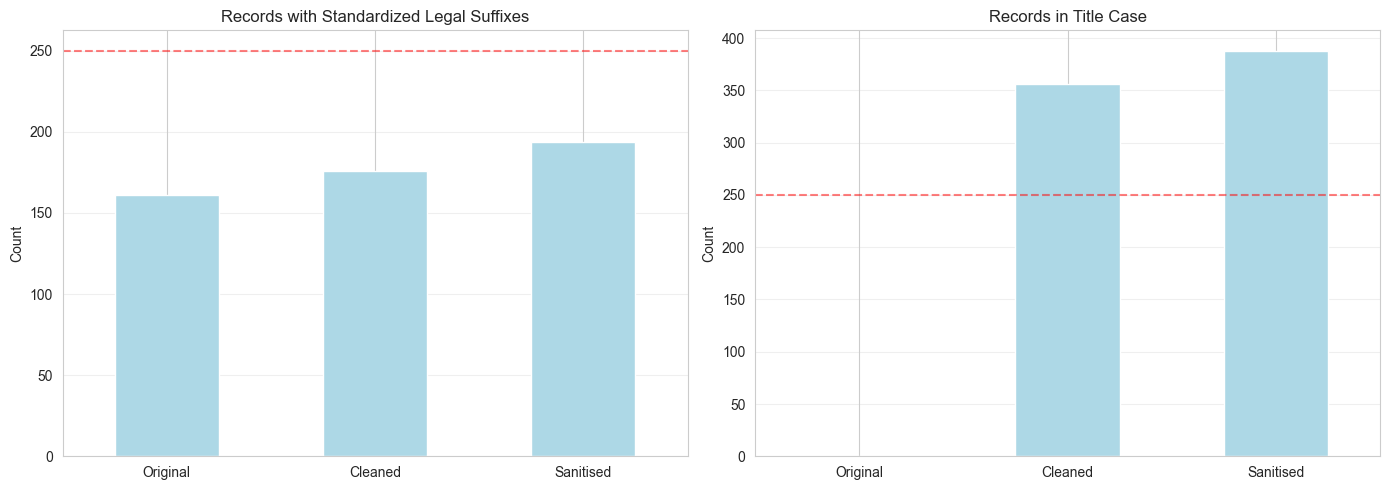

In [13]:
# ============================================
# STANDARDIZATION METRICS
# ============================================

def has_standard_suffix(name):
    """Check if name has a standardized legal suffix"""
    if pd.isna(name):
        return False
    suffixes = ['PTY LTD', 'LTD', 'LIMITED', 'INC', 'LLC', 'PLC', 'CORPORATION', 'CORP', 
                'CO.', 'GMBH', 'SA', 'AB', 'NV', 'BV', 'SDN BHD', 'PTE LTD']
    name_upper = name.upper()
    return any(name_upper.endswith(suffix) for suffix in suffixes)

def is_title_case(name):
    """Check if name follows title case convention"""
    if pd.isna(name):
        return False
    # Simple check: first letter of each word is uppercase
    words = name.split()
    if not words:
        return False
    return all(word[0].isupper() if word else False for word in words if len(word) > 0)

df['standard_suffix_original'] = df['original_name'].apply(has_standard_suffix)
df['standard_suffix_cleaned'] = df['cleaned_name'].apply(has_standard_suffix)
df['standard_suffix_sanitised'] = df['sanitised_name'].apply(has_standard_suffix)

df['title_case_original'] = df['original_name'].apply(is_title_case)
df['title_case_cleaned'] = df['cleaned_name'].apply(is_title_case)
df['title_case_sanitised'] = df['sanitised_name'].apply(is_title_case)

print("=== STANDARDIZATION METRICS ===")
print(f"\nRecords with standardized legal suffixes:")
print(f"  Original:  {df['standard_suffix_original'].sum()} ({df['standard_suffix_original'].mean()*100:.1f}%)")
print(f"  Cleaned:   {df['standard_suffix_cleaned'].sum()} ({df['standard_suffix_cleaned'].mean()*100:.1f}%)")
print(f"  Sanitised: {df['standard_suffix_sanitised'].sum()} ({df['standard_suffix_sanitised'].mean()*100:.1f}%)")

print(f"\nRecords in title case:")
print(f"  Original:  {df['title_case_original'].sum()} ({df['title_case_original'].mean()*100:.1f}%)")
print(f"  Cleaned:   {df['title_case_cleaned'].sum()} ({df['title_case_cleaned'].mean()*100:.1f}%)")
print(f"  Sanitised: {df['title_case_sanitised'].sum()} ({df['title_case_sanitised'].mean()*100:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Standard suffixes
suffix_data = pd.DataFrame({
    'Original': [df['standard_suffix_original'].sum()],
    'Cleaned': [df['standard_suffix_cleaned'].sum()],
    'Sanitised': [df['standard_suffix_sanitised'].sum()]
})
suffix_data.T.plot(kind='bar', ax=axes[0], legend=False, color=['lightblue', 'lightgreen', 'peachpuff'])
axes[0].set_ylabel('Count')
axes[0].set_title('Records with Standardized Legal Suffixes')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(y=len(df)/2, color='red', linestyle='--', alpha=0.5, label='50% threshold')

# Title case
title_data = pd.DataFrame({
    'Original': [df['title_case_original'].sum()],
    'Cleaned': [df['title_case_cleaned'].sum()],
    'Sanitised': [df['title_case_sanitised'].sum()]
})
title_data.T.plot(kind='bar', ax=axes[1], legend=False, color=['lightblue', 'lightgreen', 'peachpuff'])
axes[1].set_ylabel('Count')
axes[1].set_title('Records in Title Case')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=len(df)/2, color='red', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.show()


In [14]:
# ============================================
# COMPREHENSIVE SUMMARY
# ============================================

print("="*70)
print("COMPREHENSIVE COMPARISON SUMMARY: CLEANED vs SANITISED")
print("="*70)

summary_data = {
    'Metric': [
        'Average Levenshtein Distance',
        'Normalized Distance (%)',
        'Sequence Similarity',
        'Token Overlap (Jaccard)',
        'Average Length Change',
        'Average Token Change',
        'Closer to Original (%)',
        'Standard Legal Suffixes (%)',
        'Title Case Formatting (%)',
        'Average Digit Change',
        'Average Special Char Change',
        'Average Case Change'
    ],
    'Cleaned': [
        f"{df['lev_dist_cleaned'].mean():.2f}",
        f"{df['lev_dist_cleaned_norm'].mean():.2f}%",
        f"{df['similarity_cleaned'].mean():.3f}",
        f"{df['token_overlap_cleaned'].mean():.3f}",
        f"{df['len_change_cleaned'].mean():+.2f}",
        f"{df['token_change_cleaned'].mean():+.2f}",
        f"{(df['which_closer']=='cleaned').sum()/len(df)*100:.1f}%",
        f"{df['standard_suffix_cleaned'].mean()*100:.1f}%",
        f"{df['title_case_cleaned'].mean()*100:.1f}%",
        f"{df['digit_change_cleaned'].mean():+.2f}",
        f"{df['special_change_cleaned'].mean():+.2f}",
        f"{df['case_change_cleaned'].mean():.2f}"
    ],
    'Sanitised': [
        f"{df['lev_dist_sanitised'].mean():.2f}",
        f"{df['lev_dist_sanitised_norm'].mean():.2f}%",
        f"{df['similarity_sanitised'].mean():.3f}",
        f"{df['token_overlap_sanitised'].mean():.3f}",
        f"{df['len_change_sanitised'].mean():+.2f}",
        f"{df['token_change_sanitised'].mean():+.2f}",
        f"{(df['which_closer']=='sanitised').sum()/len(df)*100:.1f}%",
        f"{df['standard_suffix_sanitised'].mean()*100:.1f}%",
        f"{df['title_case_sanitised'].mean()*100:.1f}%",
        f"{df['digit_change_sanitised'].mean():+.2f}",
        f"{df['special_change_sanitised'].mean():+.2f}",
        f"{df['case_change_sanitised'].mean():.2f}"
    ],
    'Winner': [
        'Sanitised ✓' if df['lev_dist_sanitised'].mean() < df['lev_dist_cleaned'].mean() else 'Cleaned',
        'Sanitised ✓' if df['lev_dist_sanitised_norm'].mean() < df['lev_dist_cleaned_norm'].mean() else 'Cleaned',
        'Sanitised ✓' if df['similarity_sanitised'].mean() > df['similarity_cleaned'].mean() else 'Cleaned',
        'Sanitised ✓' if df['token_overlap_sanitised'].mean() > df['token_overlap_cleaned'].mean() else 'Cleaned',
        'Tie',
        'Sanitised ✓' if abs(df['token_change_sanitised'].mean()) < abs(df['token_change_cleaned'].mean()) else 'Cleaned',
        'Sanitised ✓' if (df['which_closer']=='sanitised').sum() > (df['which_closer']=='cleaned').sum() else 'Cleaned',
        'Sanitised ✓' if df['standard_suffix_sanitised'].mean() > df['standard_suffix_cleaned'].mean() else 'Cleaned',
        'Cleaned ✓' if df['title_case_cleaned'].mean() > df['title_case_sanitised'].mean() else 'Sanitised',
        'Sanitised ✓' if abs(df['digit_change_sanitised'].mean()) < abs(df['digit_change_cleaned'].mean()) else 'Cleaned',
        'Sanitised ✓' if abs(df['special_change_sanitised'].mean()) < abs(df['special_change_cleaned'].mean()) else 'Cleaned',
        'Sanitised ✓' if df['case_change_sanitised'].mean() < df['case_change_cleaned'].mean() else 'Cleaned'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))
print("\n")

# Key insights
print("="*70)
print("KEY INSIGHTS:")
print("="*70)
print(f"""
1. EDIT DISTANCE: Sanitised makes {df['lev_dist_cleaned'].mean()/df['lev_dist_sanitised'].mean():.1f}x fewer edits on average

2. SIMILARITY: Sanitised maintains {df['similarity_sanitised'].mean():.1%} similarity vs 
   Cleaned's {df['similarity_cleaned'].mean():.1%}

3. PRESERVATION: In {(df['which_closer']=='sanitised').sum()} cases ({(df['which_closer']=='sanitised').sum()/len(df)*100:.1f}%), 
   Sanitised stayed closer to original

4. STANDARDIZATION: Sanitised achieves {df['standard_suffix_sanitised'].mean()*100:.1f}% suffix standardization vs 
   Cleaned's {df['standard_suffix_cleaned'].mean()*100:.1f}%

5. CONSISTENCY: {(df['lev_dist_sanitised']==0).sum()} records ({(df['lev_dist_sanitised']==0).sum()/len(df)*100:.1f}%) 
   unchanged by Sanitised vs {(df['lev_dist_cleaned']==0).sum()} ({(df['lev_dist_cleaned']==0).sum()/len(df)*100:.1f}%) by Cleaned
""")


COMPREHENSIVE COMPARISON SUMMARY: CLEANED vs SANITISED


                      Metric Cleaned Sanitised      Winner
Average Levenshtein Distance    3.89      1.32 Sanitised ✓
     Normalized Distance (%)  13.63%     4.17% Sanitised ✓
         Sequence Similarity   0.932     0.975 Sanitised ✓
     Token Overlap (Jaccard)   0.758     0.925 Sanitised ✓
       Average Length Change   +0.81     -0.91         Tie
        Average Token Change   +0.12     -0.12     Cleaned
      Closer to Original (%)    5.6%     34.8% Sanitised ✓
 Standard Legal Suffixes (%)   35.2%     38.8% Sanitised ✓
   Title Case Formatting (%)   71.2%     77.6%   Sanitised
        Average Digit Change   -0.26     -0.66     Cleaned
 Average Special Char Change   +0.21     -0.20 Sanitised ✓
         Average Case Change    4.18      5.10     Cleaned


KEY INSIGHTS:

1. EDIT DISTANCE: Sanitised makes 2.9x fewer edits on average

2. SIMILARITY: Sanitised maintains 97.5% similarity vs 
   Cleaned's 93.2%

3. PRESERVATION: In 

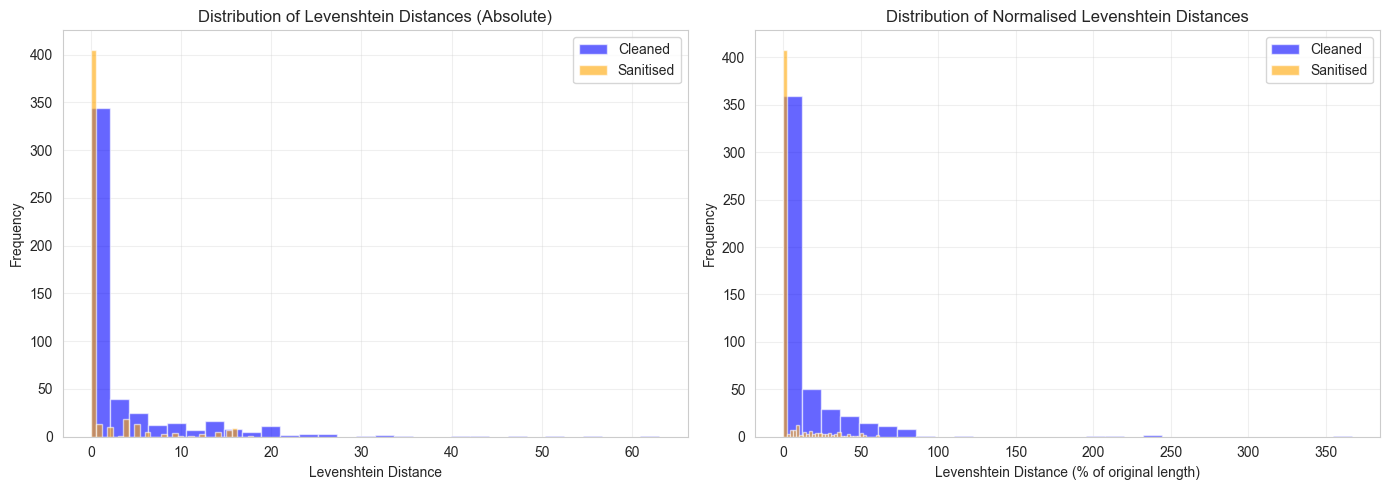


=== COMPARISON SUMMARY ===

Average Levenshtein Distance:
  Cleaned:   3.89
  Sanitised: 1.32

Median Levenshtein Distance:
  Cleaned:   0.00
  Sanitised: 0.00

Average Normalised Distance (% of original):
  Cleaned:   13.63%
  Sanitised: 4.17%


In [15]:
# Visualization: Distribution of Levenshtein distances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute distances
axes[0].hist(df['lev_dist_cleaned'], bins=30, alpha=0.6, label='Cleaned', color='blue')
axes[0].hist(df['lev_dist_sanitised'], bins=30, alpha=0.6, label='Sanitised', color='orange')
axes[0].set_xlabel('Levenshtein Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Levenshtein Distances (Absolute)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalized distances
axes[1].hist(df['lev_dist_cleaned_norm'], bins=30, alpha=0.6, label='Cleaned', color='blue')
axes[1].hist(df['lev_dist_sanitised_norm'], bins=30, alpha=0.6, label='Sanitised', color='orange')
axes[1].set_xlabel('Levenshtein Distance (% of original length)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Normalised Levenshtein Distances')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n=== COMPARISON SUMMARY ===")
print(f"\nAverage Levenshtein Distance:")
print(f"  Cleaned:   {df['lev_dist_cleaned'].mean():.2f}")
print(f"  Sanitised: {df['lev_dist_sanitised'].mean():.2f}")
print(f"\nMedian Levenshtein Distance:")
print(f"  Cleaned:   {df['lev_dist_cleaned'].median():.2f}")
print(f"  Sanitised: {df['lev_dist_sanitised'].median():.2f}")
print(f"\nAverage Normalised Distance (% of original):")
print(f"  Cleaned:   {df['lev_dist_cleaned_norm'].mean():.2f}%")
print(f"  Sanitised: {df['lev_dist_sanitised_norm'].mean():.2f}%")
